This notebook uses the thickness_sim library to show the falicy of measuring a single line of thickness points across the net to determine thickness range.  This is assuming the predominant cause of thickness variation is the slots in the die.

The cell below loads thickness_sim, imports libraries, and creates an instance of the net model.

In [1]:
import thickness_sim
from math import pi
from numpy import linspace
from scipy import optimize

net = thickness_sim.NetModel()

*This cell generates the knot grid with a uniform thickness.*

In [2]:
net.create_net(100,100,pi/4,pi/4,40,1,.03)

In [3]:
net.print_net_stats()

Width = 40.00 Length = 40.00 Target Thickness = 0.030
Number of knots: 20201
Number of slots in inside die: 100
Number of slots in outside die: 100
Net is symmetrical, angle = 90.0 deg.
Thickness average of all knots = 0.0300
Thickness max = 0.0300, min = 0.0300, range = 0.0000


The cell below adds the variation in the inside and outside die directions.

In [4]:
net.set_thickness(.030)
net.indie_variator(1,.001)
net.outdie_variator(1,.001)
net.print_net_stats()

Width = 40.00 Length = 40.00 Target Thickness = 0.030
Number of knots: 20201
Number of slots in inside die: 100
Number of slots in outside die: 100
Net is symmetrical, angle = 90.0 deg.
Thickness average of all knots = 0.0300
Thickness max = 0.0320, min = 0.0280, range = 0.0040


Below is a plot of the variation added.

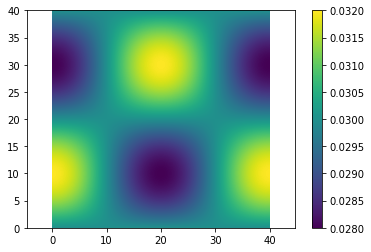

In [5]:
net.clear_probe_pts()
net.plot_2d_contour()


The cell below puts a line of 10 probe points across the web 10" from start.  This appears to cross where there is a high range.

In [6]:
net.clear_probe_pts()
net.create_dataframe()
net.add_probe_line_across(10)

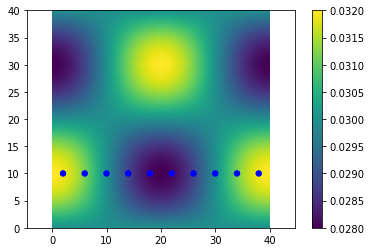

In [7]:
net.plot_2d_contour()

Below executes the measurements then prints the stats.

In [8]:
net.execute_probe()
net.print_probe_stats()


Number of samples = 10
Average thickness = 0.0302
Max thickness = 0.0320
Min thickness = 0.0282
Thickness range = 0.0038




The probe point below is at 19" which looks to be a point that will give a low range. 

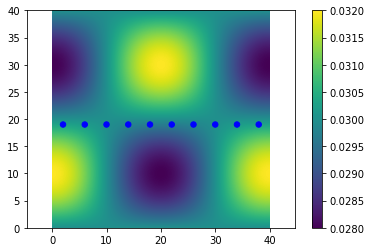


Number of samples = 10
Average thickness = 0.0302
Max thickness = 0.0305
Min thickness = 0.0300
Thickness range = 0.0005




In [9]:
net.clear_probe_pts()
net.add_probe_line_across(19)
net.execute_probe()
net.plot_2d_contour()
net.print_probe_stats()

In [10]:
dps = [] 
for y in linspace(0, 22, 10):
    net.clear_probe_pts()
    net.add_probe_line_across(y)
    net.execute_probe()
    dps.append((y, net.avg_probe_thkns(), net.thkns_range_probe()))
# for dp in dps:
#     print('y={:5.2f} avg={:6.4f} thkns={:6.4f}'.format(*dp))

The cell below graphs the thickness range from 0 to 22 inches up from bottom.  You can see that most measurements are well below the known true peak of .004.

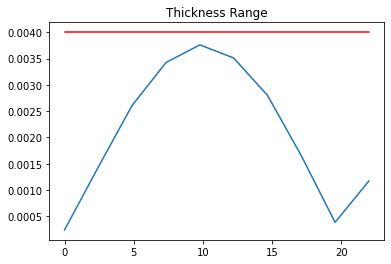

In [11]:
# %matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('tkAgg')

plt.figure()
x = [x[0] for x in dps]
y_range = [x[2] for x in dps]
plt.title('Thickness Range')
plt.plot(x, y_range)
plt.plot([0, 22], [.004, .004], color='r')

The average is plotted below.  It is much more stable than the range.

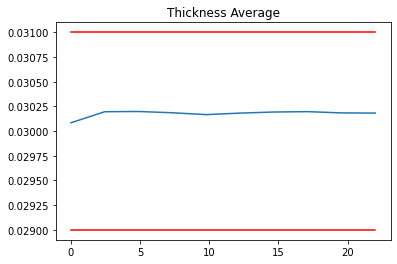

In [12]:
# %matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('tkAgg')

plt.figure()
x = [x[0] for x in dps]
y_avg = [x[1] for x in dps]
plt.title('Thickness Average')
plt.plot(x,y_avg)
plt.plot([0, 22], [.029, .029], color='r')
plt.plot([0, 22], [.031, .031], color='r')


**The variation in measured thickness range.

In [13]:
max(y_range)-min(y_range)

0.0035171676241341765

**This section will test using two rows of 10 measurements. I will try to find the opitimum spacing of the rows.**

The cell below defines a function to use to optimize the spacing between rows.



In [14]:
def max_range_error(gap):
    r_err = 0
    for y in range(40):
        net.clear_probe_pts()
        net.add_probe_line_across(y)
        net.add_probe_line_across(y + gap)
        net.execute_probe()
        new_r_err = .004 - net.thkns_range_probe()
        r_err = max(r_err, new_r_err)
    return r_err

result = optimize.minimize_scalar(max_range_error, bracket=(7.5, 12.5))
result

     fun: 0.003353107189397797
    nfev: 39
     nit: 35
 success: True
       x: 15.590170266314264

In [15]:
best_gap = result.x



In [16]:
max_range_error(10)

0.003353107189397797

In [38]:
max_range_error(5)

0.003353107189397797

In [39]:
x = [*range(20)]

In [40]:
y = [max_range_error(xx) for xx in x]

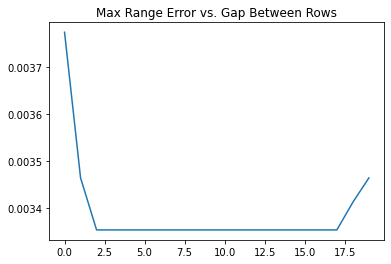

In [41]:
plt.figure()
plt.title('Max Range Error vs. Gap Between Rows')
plt.plot(x,y)

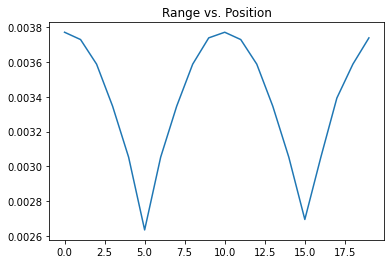

In [42]:
def range_2rows(pos, gap):
    r_err = 0
    net.clear_probe_pts()
    net.add_probe_line_across(pos)
    net.add_probe_line_across(pos + gap)
    net.execute_probe()
    return net.thkns_range_probe()

gap = 10
x = [*range(20)]
y = [range_2rows(pos, 10) for pos in x]

plt.figure()
plt.title('Range vs. Position')
plt.plot(x,y)


In [43]:
print('Average of range readings = {}'.format(sum(y) / len(y)))

Average of range readings = 0.0033899458864503815


In [44]:
count = 0
tol = .003
for pt in y:
    if pt > tol:
        count += 1
print('{} out of {} readings are greater than {}'.format(count, len(y), tol))

18 out of 20 readings are greater than 0.003


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

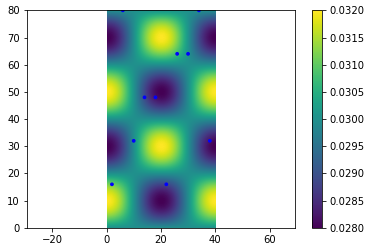

In [54]:
net.clear_probe_pts()
y_step = 16
probe_list = ((.05, y_step),
              (.15, y_step),
              (.25, y_step),
              (.35, y_step),
              (.45, y_step),
              (.55, y_step),
              (.65, y_step),
              (.75, y_step),
              (.85, y_step),
              (.95, y_step*)
net.add_probe_pts_from_list(probe_list) 
net.plot_2d_contour()

In [55]:
net.execute_probe()
net.print_probe_stats()


Number of samples = 10
Average thickness = 0.0297
Max thickness = 0.0312
Min thickness = 0.0282
Thickness range = 0.0030




In [56]:
dps = [] 
for y in linspace(0, 22, 50):
    net.clear_probe_pts()
    net.add_probe_pts_from_list(probe_list, md_start=y)
    net.execute_probe()
    dps.append((y, net.avg_probe_thkns(), net.thkns_range_probe()))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

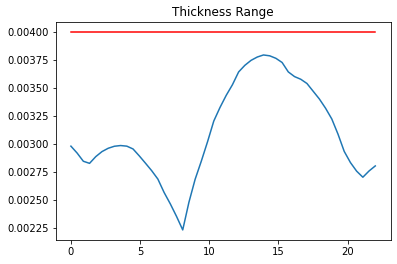

In [61]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
x = [x[0] for x in dps]
y_range = [x[2] for x in dps]
plt.title('Thickness Range')
plt.plot(x, y_range)
plt.plot([0, 22], [.004, .004], color='r')

**This thickness range variation is better but not perfect and never gets within .001 of the true range.

In [58]:
max(y_range) - min(y_range)

0.0015650636859064239

In [17]:
net2 = thickness_sim.NetModel()

In [18]:
net2.create_net(250, 250,pi/4, pi/4, 40, 1, .03)

In [19]:
net2.indie_variator(1,.001)
net2.outdie_variator(1,.001)

In [20]:
net2.add_probe_line_across(10)

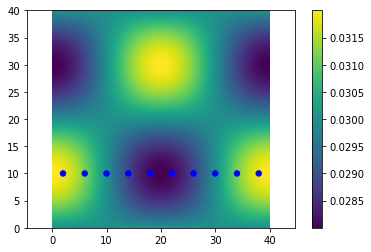

In [21]:
net2.plot_2d_contour()

In [22]:
net.print_net_stats()


Width = 40.00 Length = 40.00 Target Thickness = 0.030
Number of knots: 20201
Number of slots in inside die: 100
Number of slots in outside die: 100
Net is symmetrical, angle = 90.0 deg.
Thickness average of all knots = 0.0300
Thickness max = 0.0320, min = 0.0280, range = 0.0040


In [23]:
net2.create_dataframe()

In [24]:
net2.execute_probe()

In [25]:
net2.print_probe_stats()


Number of samples = 10
Average thickness = 0.0302
Max thickness = 0.0320
Min thickness = 0.0282
Thickness range = 0.0038


